#### Zid: z5285206
#### Name: Zhao Huang

# Introduction
In the modern world, driving is one of the most essential modes of transportation. In order to prevent drivers from disobeying traffic signs, avoid dangers, and promote safer driving, this computer vision project focuses on developing LeNet model that employ forward-sensing cameras to recognise traffic signals.

# Data Source
Source: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
Description: For this project, we will use this GTSRB - German Traffic Sign Recognition Benchmark dataset. This is because it is large, lifelike database and contains 43 classes of images and more than 50,000 images. In addition, the images are in RGB with 30x30 pixels and the test folder contains 12.6k images. What's more, the size of images is between 30 x 25 and 266 x 232.

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from PIL import Image
import os
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

# Exploratory Analysis of Data or RL Tasks:
This dataset contains 43 classes of images and more than 50,000 images. In addition, the images are in RGB with 30x30 pixels and the test folder contains 12.6k images. The size of images are between 30 x 25 and 266 x 232.

The number of training images of all the classes are shown in the figure. The difference between the least number of class images of "Dangerous Curve Left" and the largest number of class images of "Speed limit (50km/h)" is around 2000, which is not very significant compared to the number of the total images (50,000). Thus, resampling is not neccessary in this dataset.

In order to improve the accuracy of model training, we increased the number of convolutional layers from 2 to 3, and kept only one max pooling, and also, in order to increase the nonlinear relationship between the layers in the model, we set the activation to ReLU.
After being Flattened, the result will be passed to fully connected layers consisting of three Dense Layers, and between every two Dense Layers we added a dropout to prevent overfitting of the training data and the best parameter for dropout is 0.2 and 0.5. Finally, after softmax processing, we will output 43 classified results

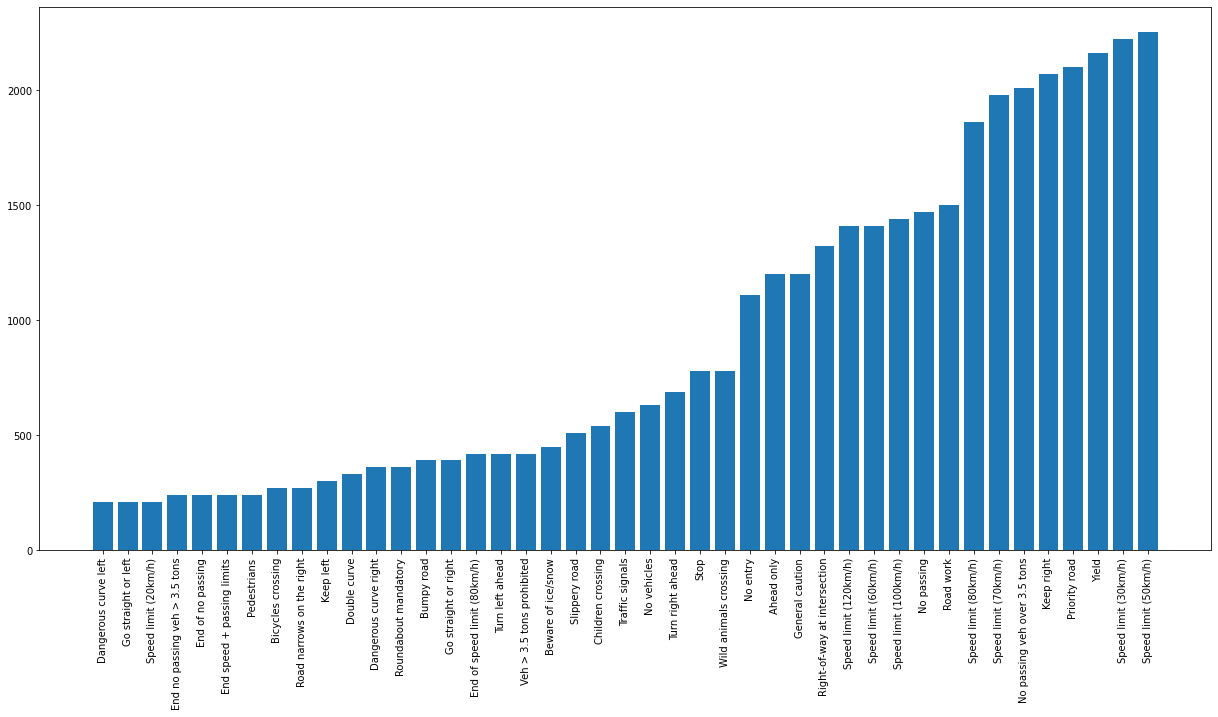

In [ ]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

trainFolder = '/kaggle/input/gtsrb-german-traffic-sign/Train'
trainFolders = os.listdir(trainFolder)

trainNumber = []
classNum = []

for folder in trainFolders:
    trainFiles = os.listdir(trainFolder + '/' + folder)
    trainNumber.append(len(trainFiles))
    classNum.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipList = zip(trainNumber, classNum)
sortedPairs = sorted(zipList)
tuples = zip(*sortedPairs)
trainNumber, classNum = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(classNum, trainNumber)
plt.xticks(classNum, rotation='vertical')
plt.show()

### Pre-processing Method

The input images are center cropped and scaled to 30 x 30. Additionally, photos are submitted using the rotation method. The model becomes less sensitive to the proportions of features and is able to avoid gradient explosion  or disappearance thanks to the normalization of image matrix values, which ensures the best comparison between data collecting techniques and texture instances.

## Challenging Aspect
The fact that the size of the photographs presented varies is a challenge, though. The training speed will slow down if the image size is set to the maximum size (266 x 232). The processing of huge photos can take longer, and the RAM memory limit may be surpassed as a result of the size of the batch, which can also contribute to this. Therefore, appropriate preprocessing techniques are required to boost training efficiency while preserving test validity.

In [ ]:
basePath = '../input/gtsrb-german-traffic-sign/'
data = pd.read_csv('../input/gtsrb-german-traffic-sign/Train.csv', usecols=['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId', 'Path'])
trainData = data.iloc[:, :-2]
trainLabel = data.iloc[:, -2]
trainset = []
for imgPath in data['Path']:
    try:
        image = Image.open(basePath + imgPath).convert('RGB')
        tf = transforms.Compose([
            transforms.RandomRotation(10),
            transforms.Resize(30),
            transforms.CenterCrop(30),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])  # from imagenet
        ])
        trainset.append(tf(image).numpy())
    except:
        print("Error in " + imgPath)



# Data Spliting

In [ ]:
XTrain, XValid, YTrain, YValid = train_test_split(trainset, trainLabel.values, test_size=0.2, shuffle=True)
T_dev = pd.get_dummies(YTrain).values
T_val = pd.get_dummies(YValid).values

# Model Design
This model was built based on LeNet which was one of the first released CNNs with wide applications and influence.
The traditional LeNet consists of two section: 
1. A convolutional encoder which consists of two convolutional layers.
2. A dense block which consists of three fully connected layers

In order to achieve better performance and accuracy, we trained LeNet multiple times and adjusted the parameters of LeNet according to each training result. The modified places include: Convolutional Layer​, Max Pooling​, and Dropout​. More details are in discussion part.



In [ ]:
# from keras.models import Sequential
# from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, Normalization
# from tensorflow.layers import Linear
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import *
import warnings


model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(30, 30, 3)))
# model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(filters=64, kernel_size=(5,5), padding='valid', activation='relu'))
# model.add(MaxPool2D(strides=2))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(84, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation='softmax'))

model.build()
model.summary()

Model: "sequential"

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


conv2d (Conv2D)              (None, 30, 30, 32)        2432      

_________________________________________________________________

conv2d_1 (Conv2D)            (None, 26, 26, 48)        38448     

_________________________________________________________________

max_pooling2d (MaxPooling2D) (None, 13, 13, 48)        0         

_________________________________________________________________

conv2d_2 (Conv2D)            (None, 9, 9, 64)          76864     

_________________________________________________________________

flatten (Flatten)            (None, 5184)              0         

_________________________________________________________________

dense (Dense)                (None, 256)               1327360   

_________________________________________________________________

dropout (Dropout)            (None, 256)

2022-11-16 10:20:20.709039: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


# Call back function
ReduceLROnPlateau: dynamically update the learning rate. After finding that the loss is no longer reduced or the acc is no longer increased, reduce the learning rate to improve network performance.

EarlyStopping: Callbacks for stopping training early. Stop training when the loss on the training set no longer decreases (that is, the degree of reduction is less than a certain threshold), aiming to solve the problem that the number of epochs needs to be manually set, and it can also be regarded as a way to avoid network occurrence Regularization method for overfitting


In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_acc', 
                                patience=3, 
                                verbose=1, 
                                factor=0.2, 
                                min_lr=1e-6)
callback = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

In [ ]:
adam = Adam(lr=5e-4)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)

XTrain = np.array(XTrain).reshape(len(XTrain), 30, 30, 3)
XValid = np.array(XValid).reshape(len(XValid), 30, 30, 3)
YTrain = np.array(T_dev).astype(np.float)
YValid = np.array(T_val).astype(np.float)
print(XTrain.shape)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.

  "The `lr` argument is deprecated, use `learning_rate` instead.")


(31367, 30, 30, 3)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.

Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

  

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.

Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

  import sys


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
            rotation_range=10, 
            width_shift_range=0.1, 
            height_shift_range=0.1, 
            zoom_range=0.1)
datagen.fit(XTrain)

# Training

In [ ]:
history = model.fit_generator(datagen.flow(XTrain, T_dev, batch_size=100), steps_per_epoch=len(XTrain)/100, 
                    epochs=300, validation_data=(XValid, T_val), callbacks=[callback, reduce_lr])

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.

  warnings.warn('`Model.fit_generator` is deprecated and '

2022-11-16 10:20:21.284179: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/300

313/313 [==============================] - 66s 208ms/step - loss: 3.4787 - accuracy: 0.0790 - val_loss: 3.1113 - val_accuracy: 0.1674

Epoch 2/300

313/313 [==============================] - 66s 211ms/step - loss: 2.9932 - accuracy: 0.1829 - val_loss: 2.4326 - val_accuracy: 0.3143

Epoch 3/300

313/313 [==============================] - 66s 210ms/step - loss: 2.4677 - accuracy: 0.3025 - val_loss: 1.7681 - val_accuracy: 0.4668

Epoch 4/300

313/313 [==============================] - 66s 210ms/step - loss: 2.0488 - accuracy: 0.3853 - val_loss: 1.4833 - val_accuracy: 0.5227

Epoch 5/300

313/313 [==============================] - 66s 209ms/step - loss: 1.7659 - accuracy: 0.4556 - val_loss: 1.3117 - val_accuracy: 0.5663

Epoch 6/300

313/313 [==============================] - 65s 207ms/step - loss: 1.5796 - accuracy: 0.5067 - val_loss: 1.1234 - val_accuracy: 0.6245

Epoch 7/300

313/313 [==============================] - 66s 211ms/step - loss: 1.4131 - accuracy: 0.5533 - val_l

# Accuracy Visualization (Training and Validation Result)
The changes in training accuracy and validation accuracy as the number of epochs increase are shown in the figure below

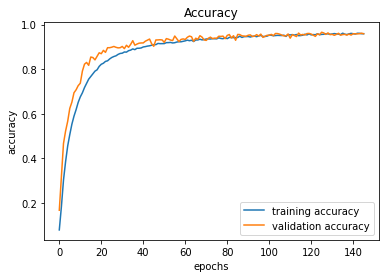

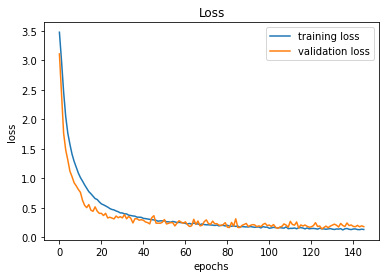

In [ ]:
import matplotlib.pyplot as plt

plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [ ]:
testData = pd.read_csv('/kaggle/input/gtsrb-german-traffic-sign/Test.csv')
testLabel = testData["ClassId"].values
testset = []

for imgPath in testData['Path']:
    try:
        image = Image.open(basePath + imgPath).convert('RGB')
        tf = transforms.Compose([
            transforms.Resize(30),
            transforms.CenterCrop(30),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])  # from imagenet
        ])
        testset.append(tf(image).numpy())
    except:
        print("Error in " + imgPath)


In [ ]:
# print(np.array(testset).shape)
XTest = np.array(testset).reshape(len(testset), 30, 30, 3)
my_Y = model.predict(XTest)
print(my_Y)
YTest = np.array(testLabel).astype(np.float)
# print(len(YTest))
# YTest = np.argmax(YTest, axis=0)

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00

  0.0000000e+00 1.4855430e-34]

 [9.6951034e-09 1.0000000e+00 2.6714602e-09 ... 2.1319984e-25

  1.3521766e-38 1.7586666e-38]

 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00

  0.0000000e+00 0.0000000e+00]

 ...

 [2.8881124e-07 5.3056884e-03 8.5809557e-03 ... 4.1571653e-05

  5.8817777e-09 3.6101462e-04]

 [1.8107767e-10 3.5612256e-04 2.1871616e-04 ... 2.7875682e-10

  6.1601071e-18 1.3747922e-13]

 [0.0000000e+00 0.0000000e+00 4.7872816e-32 ... 0.0000000e+00

  0.0000000e+00 0.0000000e+00]]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.

Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

  """


In [ ]:
XTest = np.array(testset).reshape(len(testset), 30, 30, 3)
my_Y = model.predict(XTest)
print(my_Y)
print(my_Y.shape)
my_Y = np.argmax(my_Y, axis=1)
print(YTest.shape)

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00

  0.0000000e+00 1.4855430e-34]

 [9.6951034e-09 1.0000000e+00 2.6714602e-09 ... 2.1319984e-25

  1.3521766e-38 1.7586666e-38]

 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00

  0.0000000e+00 0.0000000e+00]

 ...

 [2.8881124e-07 5.3056884e-03 8.5809557e-03 ... 4.1571653e-05

  5.8817777e-09 3.6101462e-04]

 [1.8107767e-10 3.5612256e-04 2.1871616e-04 ... 2.7875682e-10

  6.1601071e-18 1.3747922e-13]

 [0.0000000e+00 0.0000000e+00 4.7872816e-32 ... 0.0000000e+00

  0.0000000e+00 0.0000000e+00]]

(12630, 43)

(12630,)


# Generating Testing Accuracy (Testing Result)

In [ ]:
from sklearn.metrics import accuracy_score

print(YTest.shape, my_Y.shape)

accuracy_score(YTest, my_Y)

(12630,) (12630,)


0.8692794932699921

# Discussion

## Result Discussion
After customization, the final result of our LeNet is as above. From the generated statistical chart and the program output, we can see that after 146 Epoch training, the Training and Validation Accuracy finally converges to 96%, and the Test Accuracy is 87%. Compared with the traditional LeNet (2 Convolutional Layer version), the customized model has a higher accuracy rate, and the final convergence of the validation accuracy and the training accuracy is closer

## Pros
Compared with most neural networks, LeNet has a simpler neural network layer structure. The benefit of this feature is that it is easier and faster to adjust parameters. During model building, I can quickly find ways to improve parameters based on the previous training results. In addition, despite the simple structure of the model, it still achieves considerable accuracy.

## Cons
From the test results, we can know that there is a certain amount of overfitting in the model, because there is a large gap between test accuracy and training accuracy. In addition, the model takes longer (3 hours) and more epochs (146ep) to train than other models in the group.

## Future Improvement
From the results, although the validation accuracy and training accuracy finally converged to an almost equal level, the testing accuracy is still lower than them (only 87%), so there is still a certain overfitting phenomenon. In order to improve the final testing accuracy, we can use richer means to solve the impact of overfitting, such as adding more dropout layers. In addition, in order to further improve the accuracy, we can try to add more convolutional layers. Besides, By expanding the training set and adding photos of translations and horizontal reflections, we can also perform data augmentation.
